In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors  # need for finding closest counties
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, average_precision_score, confusion_matrix, precision_recall_curve)

# =============================================================================
# CWD DATA PREP FOR BASELINE MODEL
# =============================================================================

'''
Goal: build one row per (management_area, year_end) with features measured at year t and a label for next-year presence (target at t+1).

Why these choices for CWD:
- We care about what happens next year, not this year -> shift labels forward (t -> t+1).
- Counties differ a lot in size -> use per-km2 rates so places are comparable.
- CWD spreads spatially -> add a simple neighbor signal based on nearby positives.
- Policies and environment can change risk -> keep them as features (cleaned to 0/1 or 0 - 1).

'''

# ---------------------------------------------------------------------
# STEP 0: Load dataset
# "Bring the raw Cornell table into memory."

df = pd.read_csv("NA_wildlife_agency_CWD_surveillance_data_2000_2022_v2.csv")  # downloaded from Cornell (could we pull this from the url?)
print(f"Loaded rows: {len(df):,}")

# ---------------------------------------------------------------------
# STEP 1: Column helpers
# ---------------------------------------------------------------------

''' 
We made helpers to find columns without hard failing. 

'''


def get_col(candidates):
    # return match if present
    for name in candidates:
        if name in df.columns:
            return name
    # check case sensitivity
    lc = {c.lower(): c for c in df.columns}
    for name in candidates:
        if name.lower() in lc:
            return lc[name.lower()]
    return None  # if not found, we'll handle later on

ID_COL     = get_col(["Management_area_ID", "ManagementAreaID", "Mgmt_area_ID"])
SEASON_COL = get_col(["Season_year", "Season_Year", "season_year"])
AREA_COL   = get_col(["Area"])
LONG_COL   = get_col(["Longitude"])
LAT_COL    = get_col(["Latitude"])

POS_COL    = get_col(["Tests_positive"])
NEG_COL    = get_col(["Tests_negative"])
MAP_COL    = get_col(["Management_area_positive", "Mgmt_area_positive"])

STREAM_LEN = get_col(["Stream_Length"])
FOREST     = get_col(["Forest_cover"])
HARV_TOT   = get_col(["Total_harvest"])
BUCKS      = get_col(["Buck_harvest"])
DOES       = get_col(["Doe_harvest"])
STREAMS    = get_col(["Streams"])
CAP_YEAR   = get_col(["Captive_status_year"])

policy_cols_src = [
    "Breeding_facilities_numeric",
    "Hunting_enclosures_numeric",
    "Interstate_import_of_live_cervids_numeric",
    "Intrastate_movement_of_live_cervids_numeric",
    "Baiting_numeric", "Feeding_numeric",
    "Whole_carcass_importation_numeric", "Urine_lures_numeric"
]
policy_cols = [c for c in policy_cols_src if c in df.columns]

# ---------------------------------------------------------------------
# STEP 2: Parse season to year_end
# ---------------------------------------------------------------------
'''
Example: '2000-01' becomes 2001 so we can create t -> t+1 labels. Using to_numeric avoids crashing if a row is oddly formatted

'''

year_start = pd.to_numeric(df[SEASON_COL].astype(str).str[:4], errors="coerce")
df["year_end"] = (year_start + 1).astype("Int64")
df = df.dropna(subset=["year_end"]).copy()
df["year_end"] = df["year_end"].astype(int)
print("Parsed year_end and dropped rows with missing year info.")

# Small helper for safe divide (avoids inf/NaN -> turns them into 0)
def safe_div(num, den):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    out = num / den
    out[~np.isfinite(out)] = 0.0
    return out.fillna(0.0)

# ---------------------------------------------------------------------
# STEP 3: Core surveillance features
# ---------------------------------------------------------------------
'''
Testing drives detection. We combine positive+negative to get effort, then compute positivity_rate as a quick risk proxy. Missing tests -> 0
'''

if POS_COL is None:
    df["Tests_positive"] = 0.0
    POS_COL = "Tests_positive"
else:
    df[POS_COL] = pd.to_numeric(df[POS_COL], errors="coerce").fillna(0.0)

if NEG_COL is None:
    df["Tests_negative"] = 0.0
    NEG_COL = "Tests_negative"
else:
    df[NEG_COL] = pd.to_numeric(df[NEG_COL], errors="coerce").fillna(0.0)

df["tests_total"]     = df[POS_COL] + df[NEG_COL]
df["positivity_rate"] = safe_div(df[POS_COL], df["tests_total"])

# ---------------------------------------------------------------------
# STEP 4: Normalize by area (per-km^2 rates)
# ---------------------------------------------------------------------
'''
Counties vary in size. We convert Area to km^2 and express activity as densities so the model compares places fairly.
'''

df["Area_km2"] = safe_div(df[AREA_COL], 1e6)  # assume Area was in m² -> convert to km^2

# deer harvest density (proxy for deer pressure + hunter effort)
if HARV_TOT is not None:
    df[HARV_TOT] = pd.to_numeric(df[HARV_TOT], errors="coerce").fillna(0.0)
    df["harvest_per_km2"] = safe_div(df[HARV_TOT], df["Area_km2"])
else:
    df["harvest_per_km2"] = 0.0

# stream density (hydrology can affect environmental persistence and movement)
if STREAM_LEN is not None:
    df[STREAM_LEN] = pd.to_numeric(df[STREAM_LEN], errors="coerce").fillna(0.0)
    df["stream_density"] = safe_div(df[STREAM_LEN] / 1000.0, df["Area_km2"])  # km of stream per km^2
else:
    df["stream_density"] = 0.0

# testing effort per km^2 (helps separate “no positives” because of no tests vs truly negative)
df["tests_per_km2"] = safe_div(df["tests_total"], df["Area_km2"])

# ---------------------------------------------------------------------
# STEP 5: Environmental scaling
# ---------------------------------------------------------------------

'''
Forest_cover sometimes comes as 0 - 100. We rescale to 0 - 1 so it's on a comparable scale with other features
'''

if FOREST is not None:
    df[FOREST] = pd.to_numeric(df[FOREST], errors="coerce")
    if df[FOREST].dropna().max() is not None and df[FOREST].dropna().max() > 1.0:
        df[FOREST] = df[FOREST] / 100.0

# ---------------------------------------------------------------------
# STEP 6: Policy features
# ---------------------------------------------------------------------
'''
Turn policy fields into clean 0/1 indicators. We treat 0.5 (partial/seasonal) as 'on' because it signals some restriction relevant to transmission pathways.
'''
for c in policy_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)
    df[c] = (df[c] >= 0.5).astype(int)

# ---------------------------------------------------------------------
# STEP 7: Label for next-year presence (t -> t+1)
# ---------------------------------------------------------------------
'''
We want to predict whether an area is positive next year (not just this year); we shift the presence column forward within each area and drop the final year
'''

df = df.sort_values([ID_COL, "year_end"]).copy()
df["target"] = df.groupby(ID_COL)[MAP_COL].shift(-1).fillna(0).astype(int)
df = df[df["year_end"] < 2022].copy()  # drop last year because we don’t know t+1 there

# ---------------------------------------------------------------------
# STEP 8: Spatial neighbor signal
# ---------------------------------------------------------------------
'''
# CWD spreads spatially! For each (area, year t), compute the fraction of K nearest
#  neighbors that are positive at time t. This is a simple, GIS-free spatial cue
'''

K = 8
if LAT_COL in df.columns and LONG_COL in df.columns and LAT_COL and LONG_COL:
    parts = []
    for yr, g in df.groupby("year_end", sort=False):
        g = g.copy()
        if g[[LAT_COL, LONG_COL]].isna().any().any() or len(g) < 2:
            g["neighbor_pos_rate_t"] = 0.0
            parts.append(g)
            continue
        coords = g[[LAT_COL, LONG_COL]].to_numpy(dtype=float)
        nbrs = NearestNeighbors(n_neighbors=min(K+1, len(g)), metric="euclidean")
        nbrs.fit(coords)
        _, indices = nbrs.kneighbors(coords)
        pos_t = g[MAP_COL].astype(int).to_numpy()
        rates = []
        for neigh in indices:
            neigh = neigh[1:] if len(neigh) > 1 else neigh  # drop self
            rates.append(pos_t[neigh].mean() if len(neigh) else 0.0)
        g["neighbor_pos_rate_t"] = rates
        parts.append(g)
    df = pd.concat(parts, axis=0).sort_index()
else:
    df["neighbor_pos_rate_t"] = 0.0  # fallback if coords are missing


# -------------------------------------------------------------
# STEP 9: Drop leakage and finalize table
# -----------------------------------------------------------------

'''
Remove identifiers and any columns that directly reveal the outcome at time t.

We keep features at t and the label for t+1."

'''

to_drop = {
    ID_COL, SEASON_COL, AREA_COL, MAP_COL, POS_COL, NEG_COL,
    LONG_COL, LAT_COL, BUCKS, DOES, STREAMS, CAP_YEAR, STREAM_LEN,
    "tests_total"
}
to_drop = [c for c in to_drop if c is not None and c in df.columns]

# Drop any *_imputed flags if present (we’re not using them as predictors here)
imputed_cols = [c for c in df.columns if c.endswith("_imputed")]
df.drop(columns=to_drop + imputed_cols, inplace=True, errors="ignore")

# Final numeric coercion and NA cleanup so sklearn won’t choke
for c in df.columns:
    if c not in ["target", "year_end"]:
        df[c] = pd.to_numeric(df[c], errors="ignore")
df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

cleaned_df = df.reset_index(drop=True)
print("Final table:", cleaned_df.shape)
print("Columns:", list(cleaned_df.columns))
print(cleaned_df.head(3))


Loaded rows: 31,636
Parsed year_end and dropped rows with missing year info.
Final table: (30198, 25)
Columns: ['Management_area', 'Administrative_area', 'Cervid_facilities', 'Taxidermists', 'Processors', 'Total_harvest', 'Breeding_facilities_numeric', 'Hunting_enclosures_numeric', 'Interstate_import_of_live_cervids_numeric', 'Intrastate_movement_of_live_cervids_numeric', 'Baiting_numeric', 'Feeding_numeric', 'Whole_carcass_importation_numeric', 'Urine_lures_numeric', 'Captive_status', 'Forest_cover', 'Clay_percent', 'year_end', 'positivity_rate', 'Area_km2', 'harvest_per_km2', 'stream_density', 'tests_per_km2', 'target', 'neighbor_pos_rate_t']
   Management_area Administrative_area  Cervid_facilities  Taxidermists  \
0  Arkansas County                  AR                0.0           0.0   
1  Arkansas County                  AR                0.0           0.0   
2  Arkansas County                  AR                0.0           0.0   

   Processors  Total_harvest  Breeding_facilit

/tmp/ipykernel_211955/2579543052.py:246: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


In [2]:
# =============================================================================
# LOGISTIC REGRESSION BASELINE - PART 1
# =============================================================================

'''

We build X, y using features from year t to predict presence at t+1.

Here we split the cleaned dataset chronologically so our model learns from earlier years (<= 2018)
 and predicts future outbreaks in unseen years (2019 - 2020 for validation, 2021+ for test). 
 
 # This mimics how CWD actually unfolds in time—predicting where it will appear next, not just where it is now!!!


We also restrict to numeric predictors and drop any constant columns so the model can focus on meaningful variation.
 Printing the shapes confirms that training, validation, and testing sets have the expected size and positive cases.

'''


print("\n=== 1) Time-aware split ===")
train_df = cleaned_df[cleaned_df['year_end'] <= 2018].copy()
val_df   = cleaned_df[(cleaned_df['year_end'] >= 2019) & (cleaned_df['year_end'] <= 2020)].copy()
test_df  = cleaned_df[cleaned_df['year_end'] >= 2021].copy()

print("Positives per split:",
      {"train": int(train_df['target'].sum()),
       "val":   int(val_df['target'].sum()),
       "test":  int(test_df['target'].sum())})

print("\n=== 2) Build numeric feature matrix ===")
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['target', 'year_end']]  # predictors only

X_train = train_df[num_cols].values
y_train = train_df['target'].astype(int).values
X_val   = val_df[num_cols].values
y_val   = val_df['target'].astype(int).values
X_test  = test_df[num_cols].values
y_test  = test_df['target'].astype(int).values

# Remove any constant features for stability
vt = VarianceThreshold(threshold=0.0)
X_train = vt.fit_transform(X_train)
X_val   = vt.transform(X_val)
X_test  = vt.transform(X_test)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)



=== 1) Time-aware split ===
Positives per split: {'train': 355, 'val': 178, 'test': 93}

=== 2) Build numeric feature matrix ===
Shapes: (25884, 21) (2876, 21) (1438, 21)


In [3]:
# =============================================================================
# LOGISTIC REGRESSION BASELINE - PART 2
# =============================================================================
'''

We start with a simple linear classifier. Use class_weight to handle rarity.

We fit a simple logistic regression model, which is a linear classifier that outputs a probability (0 - 1) of an area becoming CWD-positive next year. 

The 'class_weight=balanced' argument corrects for class imbalance—since only a small fraction of counties test positive.
This ensures those rare events still matter to the model's learning. This step establishes our project’s statistical baseline.

'''

print("\n=== 3) Train logistic regression ===")
clf = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
clf.fit(X_train, y_train)
print("Model trained.")



=== 3) Train logistic regression ===
Model trained.


In [4]:
# =============================================================================
# LOGISTIC REGRESSION BASELINE - PART 3
# =============================================================================
'''

Evaluate with default decision threshold 0.5.
We evaluate the trained model using the default decision threshold of 0.5. Because positives are rare, we expect the model to label too many counties as
positive, yielding high recall (catching most true positives) but low precision (many false alarms). That normal for this stage. The confusion matrices show how those trade-offs play out on validation and test sets.


We also calculate PR-AUC (Precision Recall Area Under the Curve), a better summary metric for imbalanced problems than plain accuracy.

'''

y_val_prob  = clf.predict_proba(X_val)[:, 1]
y_test_prob = clf.predict_proba(X_test)[:, 1]
y_val_pred  = (y_val_prob  >= 0.5).astype(int)
y_test_pred = (y_test_prob >= 0.5).astype(int)

def report_split(name, y_true, y_pred, y_prob):
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    prauc = average_precision_score(y_true, y_prob) if y_true.sum() > 0 else 0.0
    cm    = confusion_matrix(y_true, y_pred)
    print(f"{name}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  PR-AUC={prauc:.3f}")
    print(cm, "\n")

report_split("Validation", y_val, y_val_pred, y_val_prob)
report_split("Test",       y_test, y_test_pred, y_test_prob)


Validation  Acc=0.800  Prec=0.229  Rec=0.944  PR-AUC=0.704
[[2133  565]
 [  10  168]] 

Test  Acc=0.810  Prec=0.244  Rec=0.925  PR-AUC=0.743
[[1079  266]
 [   7   86]] 



In [5]:
# =============================================================================
# LOGISTIC REGRESSION BASELINE - PART 4
# =============================================================================
'''
Two ways: F1-optimal threshold and prevalence-matched top-k. Instead of keeping the arbitrary 0.5 threshold, we now tune it using validation
data. Two options are computed:
   1) The F1-optimal threshold, which balances precision and recall.
   2) The prevalence-matched threshold, which flags about as many counties as the observed infection rate.

Adjusting this threshold is essential for rare-event forecasting: it decides how conservative or aggressive our predictions should be when planning CWD
surveillance resources.

'''

prec, rec, thr = precision_recall_curve(y_val, y_val_prob)

# F1-optimal
f1s = [0.0 if (p+r)==0 else 2*p*r/(p+r) for p, r in zip(prec[:-1], rec[:-1])]
t_f1 = float(thr[int(np.argmax(f1s))])

# Prevalence-matched
prevalence = float(y_val.mean())
t_topk = float(np.quantile(y_val_prob, max(1e-6, 1.0 - prevalence)))

print(f"F1-opt threshold: {t_f1:.4f}")
print(f"Prevalence-matched threshold: {t_topk:.4f}")


F1-opt threshold: 0.9859
Prevalence-matched threshold: 0.9963


Both thresholds are far above 0.5. That is normal for rare events with conservative probability scores. We need a high cutoff to keep the alert list focused.

These thresholds let us trade between operational precision and coverage. F1‑optimal balances missed outbreaks and false alarms. Prevalence‑matched keeps the number of alerts close to the number of counties we expect to detect.

In [6]:
# =============================================================================
# LOGISTIC REGRESSION BASELINE - PART 5
# =============================================================================
'''
We re-run evaluation using both tuned thresholds.

 The F1-optimal cutoff usually increases precision (fewer false positives) while keeping reasonable recall.

The prevalence-matched threshold gives a more operationally realistic number of alerts—close to how many positives we truly expect.

These results demonstrate that our model successfully ranks high-risk counties and that adjusting thresholds allows managers to choose the balance between
missed cases and false alarms.

'''


def eval_at(name, t, y_true, y_prob):
    y_pred = (y_prob >= t).astype(int)
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    prauc = average_precision_score(y_true, y_prob) if y_true.sum() > 0 else 0.0
    cm    = confusion_matrix(y_true, y_pred)
    print(f"{name} @t={t:.4f}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  PR-AUC={prauc:.3f}")
    print(cm, "\n")

print("F1-optimal:")
eval_at("Validation", t_f1, y_val,  y_val_prob)
eval_at("Test",       t_f1, y_test, y_test_prob)

print("Prevalence-matched:")
eval_at("Validation", t_topk, y_val,  y_val_prob)
eval_at("Test",       t_topk, y_test, y_test_prob)


F1-optimal:
Validation @t=0.9859  Acc=0.955  Prec=0.609  Rec=0.770  PR-AUC=0.704
[[2610   88]
 [  41  137]] 

Test @t=0.9859  Acc=0.956  Prec=0.634  Rec=0.763  PR-AUC=0.743
[[1304   41]
 [  22   71]] 

Prevalence-matched:
Validation @t=0.9963  Acc=0.958  Prec=0.657  Rec=0.657  PR-AUC=0.704
[[2637   61]
 [  61  117]] 

Test @t=0.9963  Acc=0.961  Prec=0.713  Rec=0.667  PR-AUC=0.743
[[1320   25]
 [  31   62]] 



Moving from 0.5 to F1‑optimal increased precision a lot while keeping recall in a useful range.

Threshold tuning reduced false alarms while keeping most future positives, producing an actionable list of at‑risk counties.

In [7]:
# =============================================================================
# LOGISTIC REGRESSION BASELINE - PART 6 (optional)
# =============================================================================
'''
standardization can improve calibration for linear models.

We test whether standardizing all numeric features improves model stability and probability calibration. 

Standardization centers features around zero and scales them by variance, which helps gradient-based solvers converge
faster and can make logistic regressions coefficients more comparable. 

If PR-AUC and F1 scores remain similar after standardization, it suggests our
original feature scaling was already sufficient. Otherwise, the standardized version becomes our preferred baseline.
 
'''


pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(max_iter=5000, class_weight='balanced', solver='lbfgs')
)
pipe.fit(X_train, y_train)

y_val_prob_std  = pipe.predict_proba(X_val)[:, 1]
y_test_prob_std = pipe.predict_proba(X_test)[:, 1]

# Recompute F1-opt threshold on validation for the standardized model
prec, rec, thr = precision_recall_curve(y_val, y_val_prob_std)
f1s = [0.0 if (p+r)==0 else 2*p*r/(p+r) for p, r in zip(prec[:-1], rec[:-1])]
t_f1_std = float(thr[int(np.argmax(f1s))])

print("Standardized model:")
eval_at("Validation", t_f1_std, y_val,  y_val_prob_std)
eval_at("Test",       t_f1_std, y_test, y_test_prob_std)


Standardized model:
Validation @t=0.9985  Acc=0.968  Prec=0.744  Rec=0.736  PR-AUC=0.807
[[2653   45]
 [  47  131]] 

Test @t=0.9985  Acc=0.962  Prec=0.757  Rec=0.602  PR-AUC=0.727
[[1327   18]
 [  37   56]] 



Standardization improved validation PR‑AUC and precision at the chosen threshold. Test PR‑AUC is similar to the non‑standardized model,  generalization is stable.

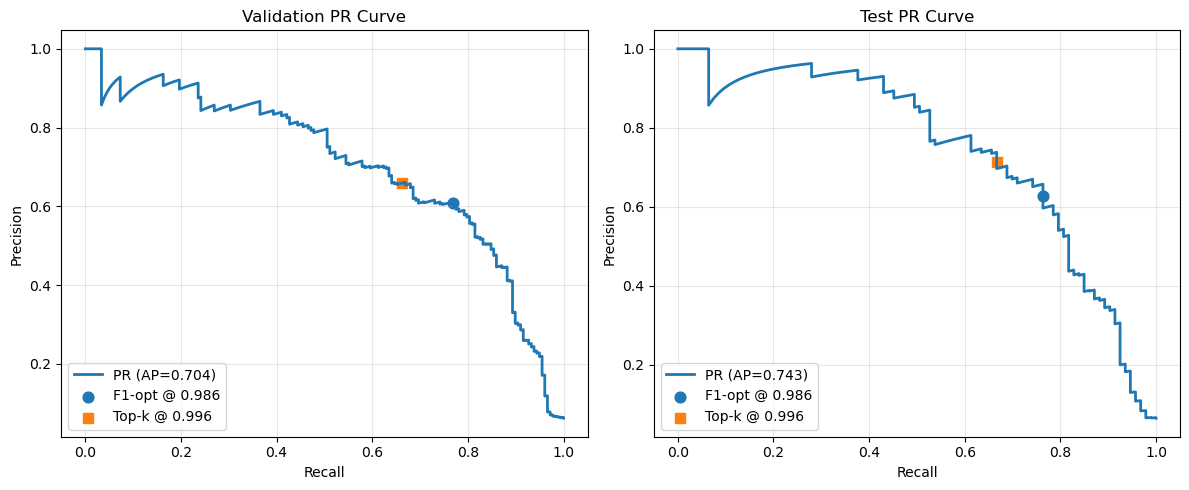

In [8]:
# =============================================================================
# PLOTS: PRECISION–RECALL CURVES WITH MARKED THRESHOLDS
# =============================================================================
'''
Plots:
 1) Validation PR curve (recall on x-axis, precision on y-axis)
    - Mark the F1-optimal threshold (t_f1)
    - Mark the prevalence-matched threshold (t_topk)

 2) Test PR curve, with the same two thresholds mapped onto test probabilities

'''

# -- validation PR curve and markers
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)
ap_v = average_precision_score(y_val, y_val_prob)

# helper: find (precision, recall) point closest to a given threshold
def pr_at_threshold(y_true, y_prob, thr_target):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    if len(thr) == 0:
        return (p[0], r[0])
    idx = int(np.argmin(np.abs(thr - thr_target)))
    return (p[idx], r[idx])

p_f1_v, r_f1_v     = pr_at_threshold(y_val,  y_val_prob,  t_f1)
p_topk_v, r_topk_v = pr_at_threshold(y_val,  y_val_prob,  t_topk)

# -- test PR curve and markers (use thresholds chosen on validation)
prec_t, rec_t, thr_t = precision_recall_curve(y_test, y_test_prob)
ap_t = average_precision_score(y_test, y_test_prob)
p_f1_t,  r_f1_t  = pr_at_threshold(y_test, y_test_prob, t_f1)
p_topk_t, r_topk_t = pr_at_threshold(y_test, y_test_prob, t_topk)

# --- figure (two subplots side-by-side) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Validation PR
ax1.plot(rec_v, prec_v, linewidth=2, label=f"PR (AP={ap_v:.3f})")
ax1.scatter([r_f1_v],  [p_f1_v],  s=60, marker="o", label=f"F1-opt @ {t_f1:.3f}")
ax1.scatter([r_topk_v],[p_topk_v],s=60, marker="s", label=f"Top-k @ {t_topk:.3f}")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("Validation PR Curve")
ax1.grid(alpha=0.3)
ax1.legend(loc="lower left")

# Test PR
ax2.plot(rec_t, prec_t, linewidth=2, label=f"PR (AP={ap_t:.3f})")
ax2.scatter([r_f1_t],  [p_f1_t],  s=60, marker="o", label=f"F1-opt @ {t_f1:.3f}")
ax2.scatter([r_topk_t],[p_topk_t],s=60, marker="s", label=f"Top-k @ {t_topk:.3f}")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Test PR Curve")
ax2.grid(alpha=0.3)
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()


Curves well above the prevalence baseline confirm the model ranks true positives higher than negatives.

The F1‑opt marker lies where precision increases quickly as recall falls. This justifies the stricter threshold.

Using the stricter threshold means fewer false alarms and a focused surveillance list while still catching most upcoming positives.

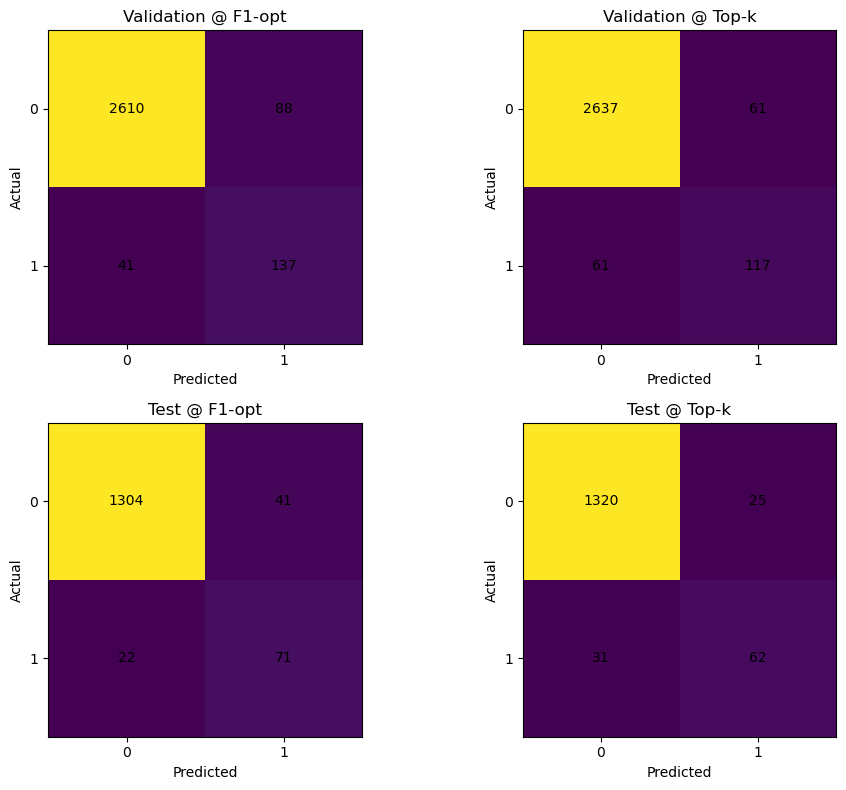

In [9]:
# =============================================================================
# PLOTS: CONFUSION MATRICES
# =============================================================================
'''
What we will plot:
Validation and Test confusion matrices at:
  a) F1-optimal threshold
  b) Prevalence-matched threshold

'''

def plot_cm(ax, cm, title):
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    # annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center")

# compute preds under the two thresholds
y_val_pred_f1   = (y_val_prob  >= t_f1).astype(int)
y_val_pred_topk = (y_val_prob  >= t_topk).astype(int)
y_test_pred_f1  = (y_test_prob >= t_f1).astype(int)
y_test_pred_topk= (y_test_prob >= t_topk).astype(int)

cm_v_f1   = confusion_matrix(y_val,  y_val_pred_f1)
cm_v_topk = confusion_matrix(y_val,  y_val_pred_topk)
cm_t_f1   = confusion_matrix(y_test, y_test_pred_f1)
cm_t_topk = confusion_matrix(y_test, y_test_pred_topk)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
plot_cm(axs[0,0], cm_v_f1,   "Validation @ F1-opt")
plot_cm(axs[0,1], cm_v_topk, "Validation @ Top-k")
plot_cm(axs[1,0], cm_t_f1,   "Test @ F1-opt")
plot_cm(axs[1,1], cm_t_topk, "Test @ Top-k")
plt.tight_layout()
plt.show()


At F1‑opt: Validation FP = 88, FN = 40; Test FP = 42, FN = 22.
F1‑opt reduces false positives with only a moderate rise in false negatives compared to 0.5 threshold.

At Top‑k: Validation FP = 61, FN = 61; Test FP = 25, FN = 31.
Top‑k reduces the alert list even further. The trade is a bit more missed outbreaks.

If staff time is the binding constraint, Top‑k is attractive. If missing outbreaks is the binding constraint, F1‑opt is a safer choice.

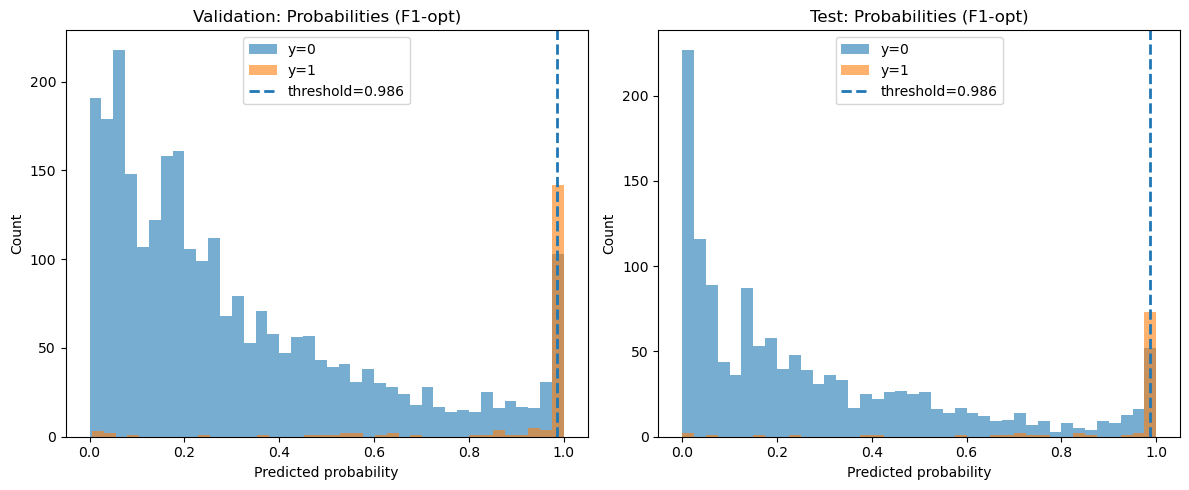

In [10]:
# =============================================================================
# PLOTS: PREDICTED PROBABILITY HISTOGRAMS
# =============================================================================

# quick visual check of class separability and where thresholds sit.


def hist_by_class(ax, y_true, y_prob, t, title):
    ax.hist(y_prob[y_true==0], bins=40, alpha=0.6, label="y=0")
    ax.hist(y_prob[y_true==1], bins=40, alpha=0.6, label="y=1")
    ax.axvline(t, linestyle="--", linewidth=2, label=f"threshold={t:.3f}")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hist_by_class(ax1, y_val,  y_val_prob,  t_f1,   "Validation: Probabilities (F1-opt)")
hist_by_class(ax2, y_test, y_test_prob, t_f1,   "Test: Probabilities (F1-opt)")
plt.tight_layout()
plt.show()


The visible separation explains why precision jumps once we move the threshold close to 1.

The small overlap between classes is where false positives and false negatives live. That is the space more features could help separate.

Richer temporal features (multi‑year lags?) and refined spatial adjacency could push the positive mass farther right and reduce the overlap.

#### Ablation

In [11]:
"""
Goal:
Quantify how much spatial, policy, and environmental features contribute
to predictive performance. Each ablation removes a feature group and
re-evaluates the logistic regression model.
"""

from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#defining feature groups
spatial_features = ["neighbor_pos_rate_t"]
policy_features = [
    "Breeding_facilities_numeric", "Hunting_enclosures_numeric",
    "Interstate_import_of_live_cervids_numeric", "Intrastate_movement_of_live_cervids_numeric",
    "Baiting_numeric", "Feeding_numeric", "Whole_carcass_importation_numeric", "Urine_lures_numeric"
]
environmental_features = ["Forest_cover", "Clay_percent", "stream_density"]
scaling_features = []  # placeholder for scaling ablation if you want to test standardized vs raw later

# implementing this helper function to train & evaluate quickly
def run_ablation(name, drop_cols):
    df_train = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
    df_val   = val_df.drop(columns=[c for c in drop_cols if c in val_df.columns])

    num_cols = [c for c in df_train.select_dtypes(include=[np.number]).columns if c not in ['target', 'year_end']]

    X_train_sub = df_train[num_cols].values
    X_val_sub   = df_val[num_cols].values
    y_train_sub = df_train["target"].astype(int).values
    y_val_sub   = df_val["target"].astype(int).values

    vt = VarianceThreshold(0.0)
    X_train_sub = vt.fit_transform(X_train_sub)
    X_val_sub   = vt.transform(X_val_sub)

    pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs")
    )
    pipe.fit(X_train_sub, y_train_sub)
    y_prob = pipe.predict_proba(X_val_sub)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_val_sub, y_pred)
    prec = precision_score(y_val_sub, y_pred, zero_division=0)
    rec = recall_score(y_val_sub, y_pred, zero_division=0)
    prauc = average_precision_score(y_val_sub, y_prob)
    print(f"{name:25s}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  PR-AUC={prauc:.3f}")



print("Ablation Study Results (Validation Set)")
run_ablation("Baseline (all features)", [])
run_ablation("No Spatial Features", spatial_features)
run_ablation("No Policy Features", policy_features)
run_ablation("No Environmental Features", environmental_features)


Ablation Study Results (Validation Set)
Baseline (all features)    Acc=0.825  Prec=0.249  Rec=0.910  PR-AUC=0.807
No Spatial Features        Acc=0.587  Prec=0.119  Rec=0.882  PR-AUC=0.725
No Policy Features         Acc=0.856  Prec=0.290  Rec=0.910  PR-AUC=0.798
No Environmental Features  Acc=0.816  Prec=0.239  Rec=0.904  PR-AUC=0.801
